In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:

bookings = pd.read_csv('C:\\Users\\chint\\OneDrive\\Desktop\\RAG-HotelBookings\\data/hotel_bookings (1).csv')

In [ ]:
bookings.shape

In [ ]:
bookings.tail()

In [ ]:
bookings.describe()

In [ ]:
bookings.info()

In [9]:
# Creating a arrival_date feature for better analysis
bookings['arrival_date'] = pd.to_datetime(bookings['arrival_date_year'].astype(str) + bookings['arrival_date_week_number'].astype(str) + '1', format='%G%V%u')

def adjust_day_of_month(row):
    calculated_date = row['arrival_date']
    day_of_month = row['arrival_date_day_of_month']
    year = row['arrival_date_year']
    month = row['arrival_date_month']

    # Trying to create a date from year, month, and day_of_month
    try:
        potential_date = pd.to_datetime(f'{year}-{month}-{day_of_month}', format='%Y-%B-%d') # %B for full month name
    except ValueError:
        return calculated_date  # If the day doesn't exist in that month, return the calculated date

    # Checking if the potential_date falls within the same week as the calculated_date
    if calculated_date.isocalendar()[1] == potential_date.isocalendar()[1]:
        return potential_date
    else:
        return calculated_date # If not in the same week, return the calculated date

bookings['arrival_date'] = bookings.apply(adjust_day_of_month, axis=1)

In [10]:
# Dropping these columsn as we have created arrival_date for better analysis
columns_to_drop =['arrival_date_year','arrival_date_month','arrival_date_week_number','arrival_date_day_of_month']
bookings = bookings.drop(columns=columns_to_drop)

In [11]:
# As there are more missing values in these features even if we impute with 0 data become sparse. So it is better to drop them.
bookings.drop(columns=['agent','company','previous_cancellations','previous_bookings_not_canceled'],axis=1,inplace=True)

In [12]:
bookings[['reservation_status_date','arrival_date']]= bookings[['reservation_status_date','arrival_date']].apply(pd.to_datetime)

C:\Users\chint\AppData\Local\Temp\ipykernel_19120\1843516156.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bookings[['reservation_status_date','arrival_date']]= bookings[['reservation_status_date','arrival_date']].apply(pd.to_datetime)


In [15]:
# total revenue for each booking
bookings['total_revenue'] = bookings['adr'] * (bookings['stays_in_weekend_nights'] + bookings['stays_in_week_nights'])

# total revenue for the particular month of the year
revenue_trends = bookings.groupby([bookings['arrival_date'].dt.year, bookings['arrival_date'].dt.month])['total_revenue'].sum()

# Renaming the index names
revenue_trends.index.names=['year','month']

# converting into dataframe

revenue_trends_df = revenue_trends.reset_index()

# Create a textual representation of the insights
revenue_trends_df['insight'] = "Total revenue for " + revenue_trends_df['month'].astype(str) + "/" + revenue_trends_df['year'].astype(str) + " was $" + revenue_trends_df['total_revenue'].round(2).astype(str)


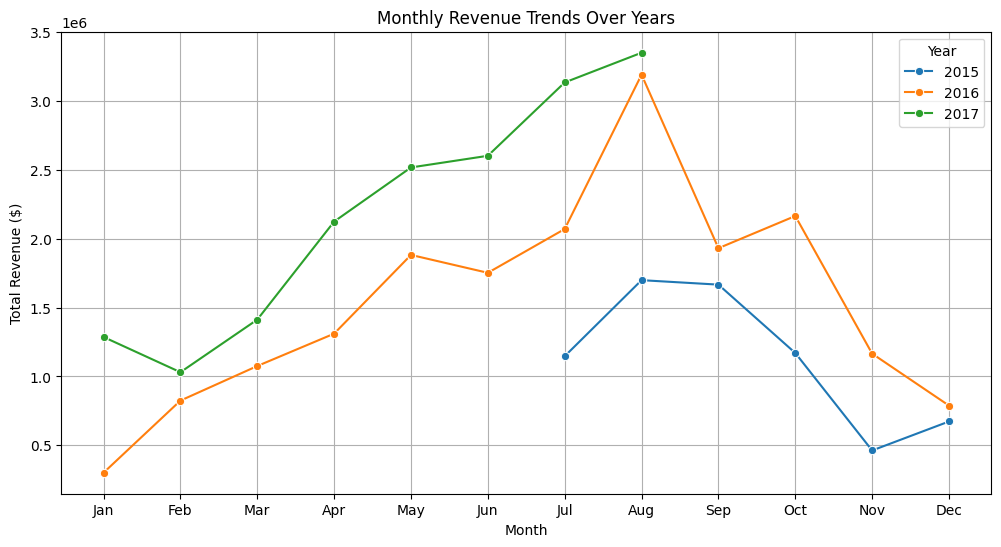

In [16]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=revenue_trends_df, x="month", y="total_revenue", hue="year", marker="o", palette="tab10")
plt.xlabel("Month")
plt.ylabel("Total Revenue ($)")
plt.title("Monthly Revenue Trends Over Years")
plt.legend(title="Year")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()


In [17]:
# Total Bookings & Cancellations
total_bookings = len(bookings)
canceled_bookings = bookings[bookings['is_canceled'] == 1].shape[0]

# Cancellation Rate Percentage
cancellation_rate = (canceled_bookings / total_bookings) * 100

print(f"Cancellation Rate: {cancellation_rate:.2f}%")


Cancellation Rate: 37.04%


In [18]:
data = [{'type':'revenue_trend','insight':i} for i in revenue_trends_df['insight']]

data.extend([{'type':'cancellation_rate','insight':cancellation_rate}])

insights_df = pd.DataFrame(data)


In [19]:
# Group by country and count the number of bookings
country_counts = bookings['country'].value_counts()

# Convert to DataFrame
country_distribution_df = country_counts.reset_index()
country_distribution_df.columns = ['country', 'count']

# Calculate percentages
country_distribution_df['percentage'] = (country_distribution_df['count'] / country_distribution_df['count'].sum()) * 100

# Create a textual representation (both percentage and count)
country_distribution_df['insight'] = country_distribution_df['country'] + " accounted for " + country_distribution_df['percentage'].round(2).astype(str) + "% of the bookings (" + country_distribution_df['count'].astype(str) + " bookings)"


In [20]:
for index, row in country_distribution_df.iterrows():
    new_row = {'type': 'country_distribution', 'insight': row['insight']}
    insights_df = pd.concat([insights_df, pd.DataFrame([new_row])], ignore_index=True)


##Plotting for top 10 countries by booking volume

C:\Users\chint\AppData\Local\Temp\ipykernel_19120\1733524421.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_bookings.index, y=country_bookings.values, palette="coolwarm")


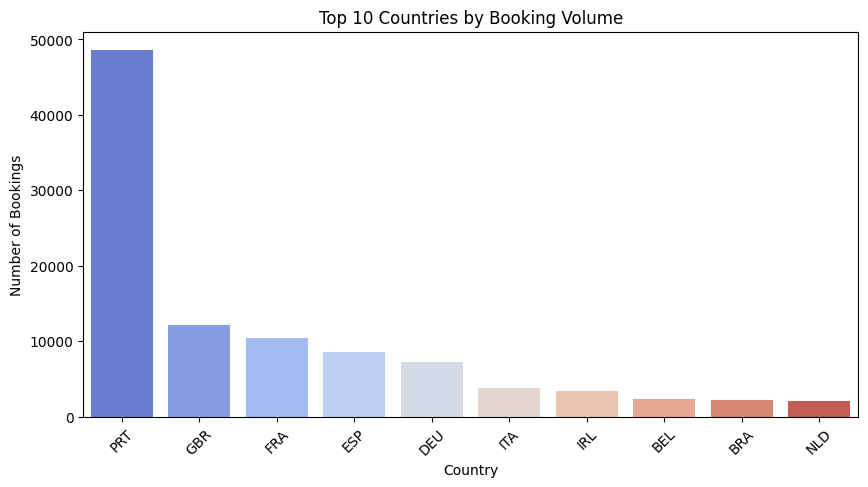

In [21]:
country_bookings = bookings['country'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=country_bookings.index, y=country_bookings.values, palette="coolwarm")
plt.xlabel("Country")
plt.ylabel("Number of Bookings")
plt.title("Top 10 Countries by Booking Volume")
plt.xticks(rotation=45)
plt.show()

In [23]:
mean_lead_time = bookings['lead_time'].mean()
median_lead_time = bookings['lead_time'].median()
std_lead_time = bookings['lead_time'].std()

# Create textual insights for the statistics
lead_time_insight_mean = f"The average lead time was {mean_lead_time:.2f} days"
lead_time_insight_median = f"The median lead time was {median_lead_time:.2f} days"
lead_time_insight_std = f"The standard deviation of lead time was {std_lead_time:.2f} days"

# 2. Create Bins for Lead Time Ranges
# ------------------------------------

# Define bins for lead time ranges (adjust these as needed)
bins = [0, 30, 90, 180, 365, np.inf]  # Up to 30 days, 31-90, 91-180, 181-365, 365+
labels = ['0-30 days', '31-90 days', '91-180 days', '181-365 days', '365+ days']

# Categorizing lead times into bins
bookings['lead_time_bin'] = pd.cut(bookings['lead_time'], bins=bins, labels=labels, right=False)

# Count bookings in each bin
lead_time_distribution = bookings['lead_time_bin'].value_counts().sort_index()

# Converting to DataFrame for easier handling
lead_time_distribution_df = lead_time_distribution.reset_index()
lead_time_distribution_df.columns = ['lead_time_range', 'count']
lead_time_distribution_df['percentage'] = (lead_time_distribution_df['count'] / lead_time_distribution_df['count'].sum())*100

# Creating textual insights for the distribution
lead_time_distribution_df['insight'] = lead_time_distribution_df['lead_time_range'].astype(str) + " had " + lead_time_distribution_df['count'].astype(str) + " bookings ("+ lead_time_distribution_df['percentage'].round(2).astype(str) + "%)"
# 3. Combine into insights_df (Corrected)
# ---------------------------------------

# Adding lead time statistics insights
data = [{'type':'lead_time_stats','insight':i} for i in [lead_time_insight_mean,lead_time_insight_median,lead_time_insight_std]]
# lead_time_bins
data.extend([{'type':'lead_time_range','insight':i} for i in lead_time_distribution_df['insight']])

new_insights_df = pd.DataFrame(data)

# Combining with the existing insights_df
insights_df = pd.concat([insights_df, new_insights_df], ignore_index=True) # Corrected line


## Plotting for the Lead Time Range

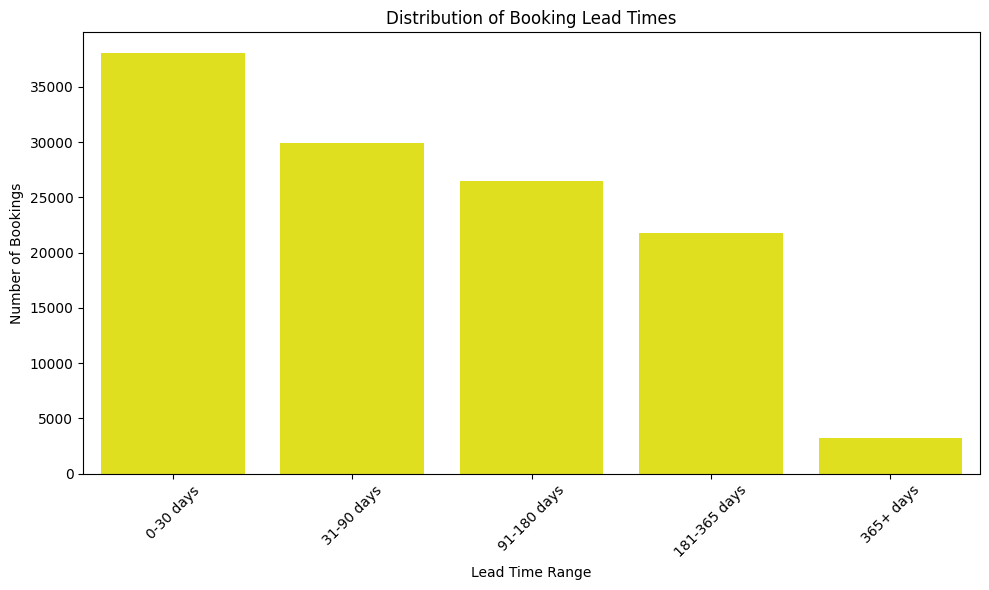

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(x='lead_time_range', y='count', data=lead_time_distribution_df, color='yellow')

plt.title('Distribution of Booking Lead Times')
plt.xlabel('Lead Time Range')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()


# grouping the hotel type and calculating total weekend and week nights

In [25]:
hotel_stays  = bookings.groupby('hotel').agg({
    'stays_in_weekend_nights' : 'sum',
    'stays_in_week_nights' : 'sum'
}
).reset_index()

hotel_stays.rename(columns = {"hotel":"Hotel Type","stays_in_weekend_nights" : "Total Stays In Weekend Nights" , "stays_in_week_nights" : "Total Stays In Week Nights"} , inplace = True)

hotel_stays

,Hotel Type,Total Stays In Weekend Nights,Total Stays In Week Nights
0,City Hotel,63082,173174
1,Resort Hotel,47664,125337


<Figure size 1000x600 with 0 Axes>

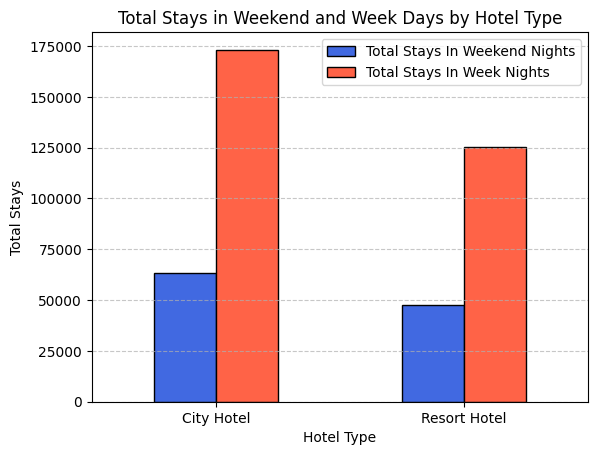

In [26]:
plt.figure(figsize=(10, 6))
hotel_stays.plot(x='Hotel Type',
                 kind='bar',
                 stacked=False,
                 color=['royalblue', 'tomato'],
                 edgecolor='black')

plt.xlabel("Hotel Type")
plt.ylabel("Total Stays")
plt.title("Total Stays in Weekend and Week Days by Hotel Type")
plt.xticks(rotation=0)
plt.legend(["Total Stays In Weekend Nights", "Total Stays In Week Nights"])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## ADR by Room Type

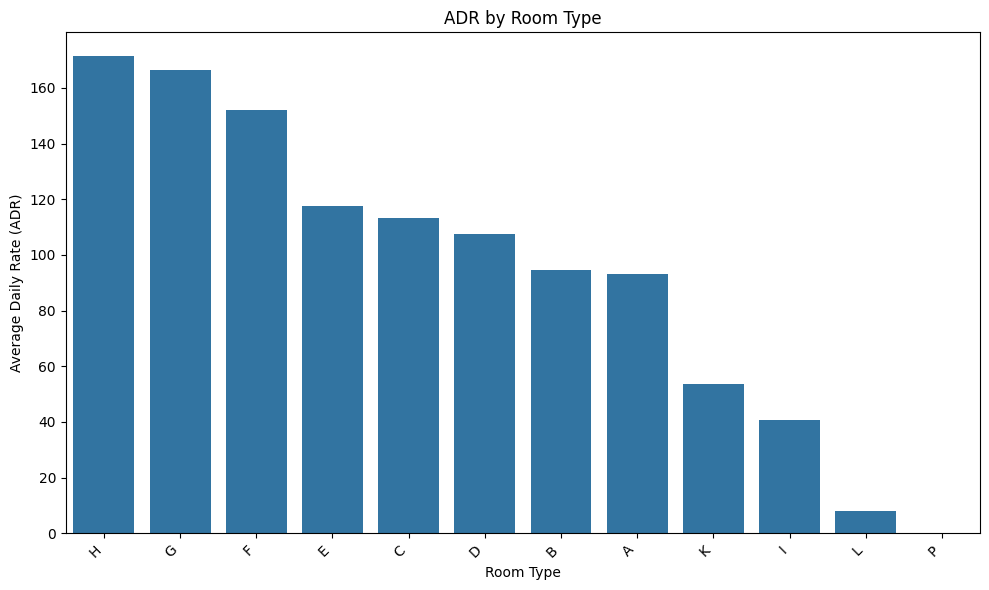

In [27]:
adr_by_room = bookings.groupby('assigned_room_type')['adr'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=adr_by_room.index, y=adr_by_room.values)
plt.title('ADR by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Daily Rate (ADR)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Cancellation Rate vs Lead Time:

C:\Users\chint\AppData\Local\Temp\ipykernel_19120\1073677237.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cancellation_vs_leadtime = bookings.groupby('lead_time_bin')['is_canceled'].mean().sort_values(ascending=False) * 100


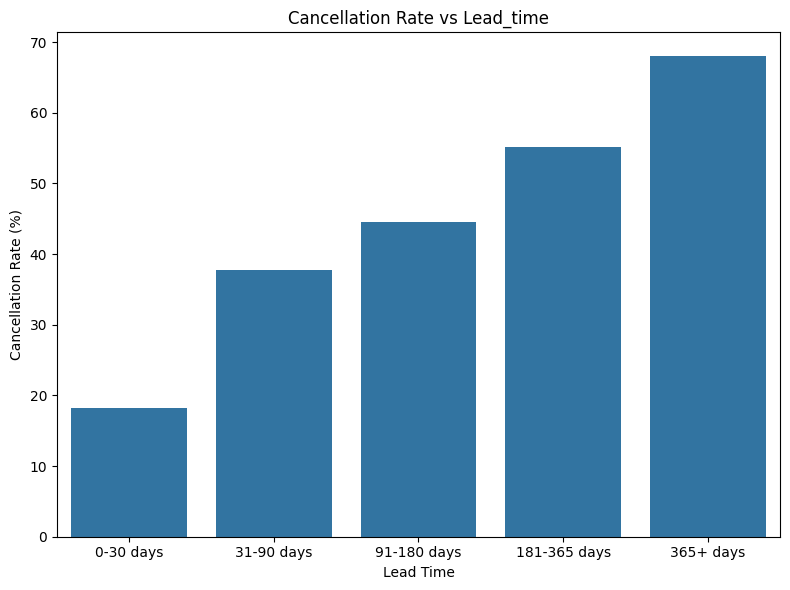

In [28]:
 # Create bins for lead time ranges (adjust these as needed)
bins = [0, 30, 90, 180, 365, np.inf]  # Up to 30 days, 31-90, 91-180, 181-365, 365+
labels = ['0-30 days', '31-90 days', '91-180 days', '181-365 days', '365+ days']

# Categorize lead times into bins
bookings['lead_time_bin'] = pd.cut(bookings['lead_time'], bins=bins, labels=labels, right=False)
cancellation_vs_leadtime = bookings.groupby('lead_time_bin')['is_canceled'].mean().sort_values(ascending=False) * 100

plt.figure(figsize=(8, 6))
sns.barplot(x=cancellation_vs_leadtime.index, y=cancellation_vs_leadtime.values)
plt.title('Cancellation Rate vs Lead_time')
plt.xlabel('Lead Time')
plt.ylabel('Cancellation Rate (%)')
plt.tight_layout()
plt.show()

# Cancellation rate by month and year

In [29]:
# Group by year and month and calculate the cancellation rate
cancellation_trends = bookings.groupby([bookings['arrival_date'].dt.year, bookings['arrival_date'].dt.month])['is_canceled'].mean() * 100
cancellation_trends.index.names = ['year', 'month']

# Convert to DataFrame
cancellation_trends_df = cancellation_trends.reset_index()
cancellation_trends_df.columns = ['year', 'month', 'cancellation_rate']
cancellation_trends_df['insight'] = "The cancellation rate for " + cancellation_trends_df['month'].astype(str) + "/" + cancellation_trends_df['year'].astype(str) + " was " + cancellation_trends_df['cancellation_rate'].round(2).astype(str) + "%"

# Add to insights_df (using the incremental approach)
data = [{'type':'cancellation_rate_by_month_year','insight':i} for i in cancellation_trends_df['insight']]

insights_df = pd.concat([insights_df,pd.DataFrame(data)],ignore_index=True)


# Cancellation rate by Hotel type

In [30]:
cancellation_by_hotel = bookings.groupby('hotel')['is_canceled'].mean() * 100
cancellation_by_hotel_df = cancellation_by_hotel.reset_index()
cancellation_by_hotel_df.columns = ['hotel', 'cancellation_rate']
cancellation_by_hotel_df['insight'] = "The cancellation rate for " + cancellation_by_hotel_df['hotel'] + " was " + cancellation_by_hotel_df['cancellation_rate'].round(2).astype(str) + "%"

data = [{'type':'cancellation_rate_by_hotel','insight':i} for i in cancellation_by_hotel_df['insight']]
insights_df = pd.concat([insights_df, pd.DataFrame(data)], ignore_index = True)

# Revenue by hotel type

In [31]:
 # Group by hotel and sum the total revenue
revenue_by_hotel = bookings.groupby('hotel')['total_revenue'].sum()
revenue_by_hotel_df = revenue_by_hotel.reset_index()
# Create a textual representation of the insights
revenue_by_hotel_df['insight'] = "Total revenue for " + revenue_by_hotel_df['hotel'] + " was $" + revenue_by_hotel_df['total_revenue'].round(2).astype(str)

data = [{'type':'revenue_by_hotel','insight':i} for i in revenue_by_hotel_df['insight']]
insights_df = pd.concat([insights_df,pd.DataFrame(data)],ignore_index=True)

# Revenue by Country

In [32]:
revenue_by_country = bookings.groupby('country')['total_revenue'].sum().sort_values(ascending=False)
revenue_by_country_df = revenue_by_country.reset_index()
revenue_by_country_df['insight'] = "Total revenue from " + revenue_by_country_df['country'] + " was $" + revenue_by_country_df['total_revenue'].round(2).astype(str)

data = [{'type':'revenue_by_country','insight':i} for i in revenue_by_country_df['insight']]
insights_df = pd.concat([insights_df, pd.DataFrame(data)], ignore_index=True)


# Lead Time vs. Cancellation (Summary): A summary statement about the relationship.

In [33]:
correlation = bookings['lead_time'].corr(bookings['is_canceled'])
lead_time_cancellation_insight = f"The correlation between lead time and cancellation is {correlation:.2f}."

new_row = {'type':'lead_time_vs_cancellation', 'insight': lead_time_cancellation_insight}
insights_df = pd.concat([insights_df, pd.DataFrame([new_row])], ignore_index=True)


# Average length of stay

In [34]:
bookings['total_stay'] = bookings['stays_in_weekend_nights'] + bookings['stays_in_week_nights']
avg_stay = bookings['total_stay'].mean()
avg_stay_insight = f"The average length of stay was {avg_stay:.2f} nights."

new_row = {'type':'avg_stay','insight':avg_stay_insight}
insights_df = pd.concat([insights_df, pd.DataFrame([new_row])], ignore_index=True)

# Average number of guests for booking

In [35]:
bookings['total_guests'] = bookings['adults'] + bookings['children'] + bookings['babies']
avg_guests = bookings['total_guests'].mean()
avg_guests_insight = f"The average number of guests per booking was {avg_guests:.2f}."

new_row = {'type': 'avg_guests','insight':avg_guests_insight}
insights_df = pd.concat([insights_df, pd.DataFrame([new_row])],ignore_index=True)

 # Booking by Market segment

In [36]:
market_segment_distribution = bookings['market_segment'].value_counts(normalize = True)*100
market_segment_distribution_df = market_segment_distribution.reset_index()
market_segment_distribution_df.columns = ['market_segment','percentage']
market_segment_distribution_df['insight'] = market_segment_distribution_df['market_segment'] + " segment constitutes " + market_segment_distribution_df['percentage'].round(2).astype(str) + "% of the total bookings"

data = [{'type':'market_segment_distribution','insight':i} for i in market_segment_distribution_df['insight']]

insights_df = pd.concat([insights_df,pd.DataFrame(data)],ignore_index=True)

# Bookings by distribution channel

In [37]:
distribution_channel_distribution = bookings['distribution_channel'].value_counts(normalize=True)*100
distribution_channel_distribution_df = distribution_channel_distribution.reset_index()
distribution_channel_distribution_df.columns = ['distribution_channel','percentage']
distribution_channel_distribution_df['insight'] = distribution_channel_distribution_df['distribution_channel'] + " constitutes " + distribution_channel_distribution_df['percentage'].round(2).astype(str) + "% of bookings"

data = [{'type':'distribution_channel_distribution','insight':i} for i in distribution_channel_distribution_df['insight']]
insights_df = pd.concat([insights_df,pd.DataFrame(data)],ignore_index=True)

# Percentage of booking requires parking


In [38]:
parking_percentage = (bookings[bookings['required_car_parking_spaces'] > 0].shape[0] / len(bookings)) * 100
parking_insight = f"{parking_percentage:.2f}% of bookings required car parking spaces."
new_row = {'type':'parking_percentage','insight':parking_insight}
insights_df = pd.concat([insights_df, pd.DataFrame([new_row])], ignore_index=True)

# Average Number of Special Requests

In [39]:

avg_special_requests = bookings['total_of_special_requests'].mean()
avg_special_requests_insight = f"The average number of special requests per booking was {avg_special_requests:.2f}."

new_row = {'type':'avg_special_requests','insight':avg_special_requests_insight}
insights_df = pd.concat([insights_df, pd.DataFrame([new_row])], ignore_index=True)

In [40]:
insights_df.to_csv('insights_df.csv', index=False)